# 付録A2: 沈黙の螺旋理論のネットワークモデル

## 学習目標
- 沈黙の螺旋理論（Spiral of Silence）の概念を理解する
- 「孤立への恐れ」をモデル化する方法を学ぶ
- メディアバイアスと世論気候の相互作用をシミュレーションする
- コア話者（オピニオンリーダー）の役割を分析する

## 難易度: 上級

---
## A2.1 沈黙の螺旋理論とは？

**沈黙の螺旋理論（Spiral of Silence）** は、ドイツの政治学者エリザベート・ノエル＝ノイマンが提唱した理論で、人々が自分の意見が少数派だと感じると発言を控え、その結果として少数派の声がさらに聞こえなくなり、多数派の意見がより支配的に見えるという悪循環を説明します。

### 理論の核心

```
少数派だと感じる → 孤立を恐れて沈黙 → 少数派の声が減る
       ↑                                      ↓
       ←←←← 多数派がより多数に見える ←←←←
```

### 主要な構成要素

| 要素 | 説明 |
|------|------|
| 世論気候の知覚 | 周囲やメディアから「何が多数派か」を推測 |
| 孤立への恐れ | 少数派になることへの心理的抵抗（個人差あり） |
| 発言意欲 | 多数派だと感じると発言しやすい |
| コア話者 | 孤立を恐れず発言し続ける人々 |

---
## A2.2 環境のセットアップ

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

print(f"NetworkX version: {nx.__version__}")
print(f"NumPy version: {np.__version__}")

NetworkX version: 3.6.1
NumPy version: 2.3.5


---
## A2.3 ステップ1: 基本関数の定義

まず、シミュレーションに必要な基本関数を定義します。

In [2]:
def logistic(x: float) -> float:
    """
    ロジスティック関数：スコアを確率に変換
    
    x が大きいほど 1 に近づき、小さいほど 0 に近づく
    """
    return 1.0 / (1.0 + np.exp(-x))

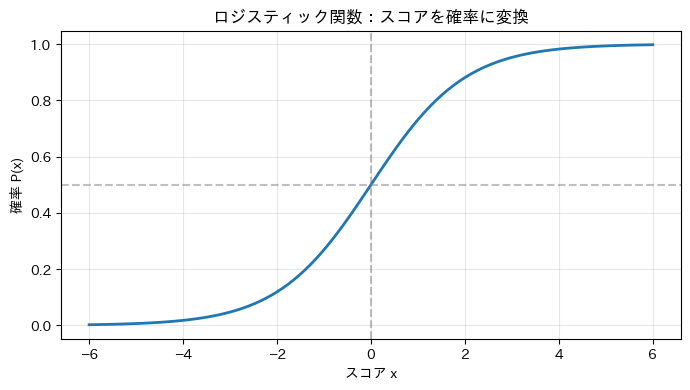

In [3]:
# ロジスティック関数の可視化
x = np.linspace(-6, 6, 100)
y = [logistic(xi) for xi in x]

plt.figure(figsize=(8, 4))
plt.plot(x, y, linewidth=2)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('スコア x')
plt.ylabel('確率 P(x)')
plt.title('ロジスティック関数：スコアを確率に変換')
plt.grid(True, alpha=0.3)
plt.show()

---
## A2.4 ステップ2: ネットワークの生成

エージェント間の関係を表すネットワークを生成します。

In [4]:
def make_graph(n: int, graph_type: str, seed: int):
    """
    指定されたタイプのネットワークを生成
    
    Parameters:
    -----------
    n : int
        ノード数
    graph_type : str
        "ER", "WS", "BA" のいずれか
    seed : int
        乱数シード
    
    Returns:
    --------
    G : networkx.Graph
        連結なグラフ
    """
    gt = graph_type.upper()
    if gt == "ER":
        G = nx.erdos_renyi_graph(n=n, p=0.02, seed=seed)
    elif gt == "WS":
        G = nx.watts_strogatz_graph(n=n, k=10, p=0.05, seed=seed)
    elif gt == "BA":
        G = nx.barabasi_albert_graph(n=n, m=3, seed=seed)
    else:
        raise ValueError("graph_type must be one of: ER, WS, BA")

    # 最大連結成分のみ使用
    if not nx.is_connected(G):
        giant = max(nx.connected_components(G), key=len)
        G = G.subgraph(giant).copy()
    return G

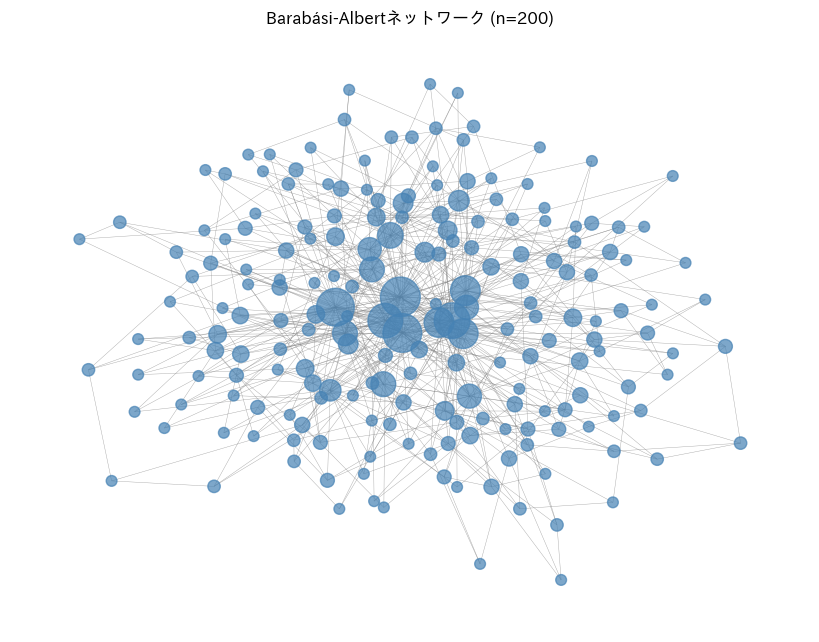

ノード数: 200
エッジ数: 591
平均次数: 5.91


In [5]:
# ネットワークの例
G_sample = make_graph(200, "BA", seed=42)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_sample, seed=42)

# 次数に応じてノードサイズを変更
degrees = dict(G_sample.degree())
node_sizes = [degrees[n] * 20 for n in G_sample.nodes()]

nx.draw(G_sample, pos, node_size=node_sizes, node_color='steelblue',
        edge_color='gray', alpha=0.7, width=0.3)
plt.title(f'Barabási-Albertネットワーク (n={len(G_sample)})')
plt.show()

print(f"ノード数: {G_sample.number_of_nodes()}")
print(f"エッジ数: {G_sample.number_of_edges()}")
print(f"平均次数: {np.mean(list(degrees.values())):.2f}")

---
## A2.5 ステップ3: エージェントの属性設定

各エージェントに以下の属性を割り当てます：

1. **私的意見 $b_i$**: 本心での賛成(1)または反対(0)
2. **孤立への恐れ $f_i$**: 少数派になることへの心理的抵抗（大きいほど沈黙しやすい）
3. **可視性 $v_i$**: その人の発言がどれだけ見えやすいか（中心性に基づく）

In [6]:
def initialize_agents(G, private_yes_rate=0.45, fear_mean=1.2, fear_sd=0.4,
                      core_fraction=0.03, weighted_visibility=True, seed=42):
    """
    エージェントの属性を初期化
    
    Parameters:
    -----------
    G : networkx.Graph
        ネットワーク
    private_yes_rate : float
        私的に賛成の割合
    fear_mean, fear_sd : float
        孤立への恐れの平均と標準偏差
    core_fraction : float
        コア話者の割合（高次数ノードから選択）
    weighted_visibility : bool
        中心性に基づく可視性重み付けを使うか
    
    Returns:
    --------
    dict: エージェント属性
    """
    rng = random.Random(seed)
    np_rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    N = len(nodes)
    
    # 私的意見
    b = {i: 1 if rng.random() < private_yes_rate else 0 for i in nodes}
    
    # 孤立への恐れ（正規分布）
    fear = {}
    for i in nodes:
        x = np_rng.normal(fear_mean, fear_sd)
        fear[i] = float(np.clip(x, 0.0, 3.0))
    
    # コア話者の選定（高次数ノード）
    degrees = dict(G.degree())
    sorted_nodes = sorted(nodes, key=lambda i: degrees[i], reverse=True)
    core_k = max(1, int(core_fraction * N))
    core = set(sorted_nodes[:core_k])
    
    # 可視性重み
    if weighted_visibility:
        deg_vals = np.array([degrees[i] for i in nodes], dtype=float)
        if deg_vals.max() == deg_vals.min():
            vis = {i: 1.0 for i in nodes}
        else:
            scaled = (deg_vals - deg_vals.min()) / (deg_vals.max() - deg_vals.min())
            vis = {i: float(0.5 + 1.5 * scaled[idx]) for idx, i in enumerate(nodes)}
    else:
        vis = {i: 1.0 for i in nodes}
    
    # 初期の公的発言
    s = {}
    for i in nodes:
        if rng.random() < 0.85:
            s[i] = b[i]  # 本心を言う
        else:
            s[i] = None  # 沈黙
    
    return {
        'b': b,
        'fear': fear,
        'core': core,
        'vis': vis,
        's': s,
        'degrees': degrees
    }

In [7]:
# エージェント属性の確認
G = make_graph(500, "BA", seed=42)
agents = initialize_agents(G, private_yes_rate=0.45, seed=42)

nodes = list(G.nodes())
print(f"ノード数: {len(nodes)}")
print(f"私的意見（賛成率）: {np.mean(list(agents['b'].values())):.1%}")
print(f"コア話者数: {len(agents['core'])}")
print(f"孤立への恐れ - 平均: {np.mean(list(agents['fear'].values())):.2f}")
print(f"孤立への恐れ - 標準偏差: {np.std(list(agents['fear'].values())):.2f}")

ノード数: 500
私的意見（賛成率）: 46.0%
コア話者数: 15
孤立への恐れ - 平均: 1.19
孤立への恐れ - 標準偏差: 0.38


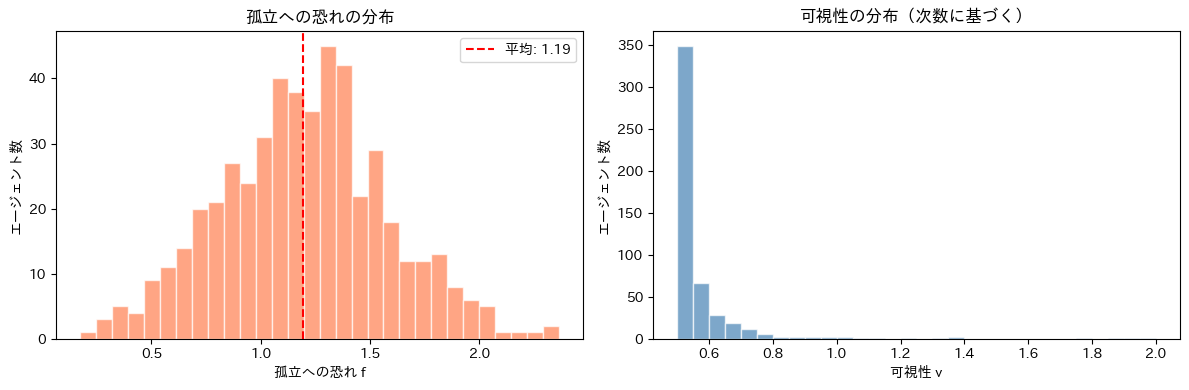

In [8]:
# 孤立への恐れの分布を可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 左: 孤立への恐れの分布
ax1 = axes[0]
fear_vals = list(agents['fear'].values())
ax1.hist(fear_vals, bins=30, edgecolor='white', alpha=0.7, color='coral')
ax1.axvline(np.mean(fear_vals), color='red', linestyle='--', 
           label=f'平均: {np.mean(fear_vals):.2f}')
ax1.set_xlabel('孤立への恐れ f')
ax1.set_ylabel('エージェント数')
ax1.set_title('孤立への恐れの分布')
ax1.legend()

# 右: 可視性の分布
ax2 = axes[1]
vis_vals = list(agents['vis'].values())
ax2.hist(vis_vals, bins=30, edgecolor='white', alpha=0.7, color='steelblue')
ax2.set_xlabel('可視性 v')
ax2.set_ylabel('エージェント数')
ax2.set_title('可視性の分布（次数に基づく）')

plt.tight_layout()
plt.show()

---
## A2.6 ステップ4: 世論気候の知覚

各エージェントは以下の情報源から「世論気候」（何が多数派か）を推測します：

1. **ローカル情報**: 隣接ノードの発言（可視性で重み付け）
2. **メディア情報**: 全体の発言平均＋バイアス

$$p_i = (1 - w) \cdot \text{local}_i + w \cdot \text{media}$$

In [9]:
def compute_media_signal(public_mean, media_bias, media_noise, np_rng):
    """
    メディアからのグローバルシグナルを計算
    
    Parameters:
    -----------
    public_mean : float
        実際の公的発言の平均
    media_bias : float
        メディアのバイアス（+なら賛成寄り）
    media_noise : float
        ノイズの標準偏差
    
    Returns:
    --------
    float: メディアシグナル [0, 1]
    """
    x = public_mean + media_bias + float(np_rng.normal(0, media_noise))
    return float(np.clip(x, 0.0, 1.0))


def compute_observed_climate(G, i, s, vis, global_signal, media_weight=0.20):
    """
    エージェントiが知覚する世論気候を計算
    
    Parameters:
    -----------
    G : networkx.Graph
        ネットワーク
    i : node
        対象エージェント
    s : dict
        現在の公的発言状態
    vis : dict
        可視性重み
    global_signal : float
        メディアシグナル
    media_weight : float
        メディアの影響度
    
    Returns:
    --------
    float: 知覚される世論気候 [0, 1]
    """
    neighbors = list(G.neighbors(i))
    
    # 近傍発言の重み付き平均（沈黙は除外）
    num = 0.0
    den = 0.0
    for j in neighbors:
        if s[j] is None:
            continue
        w = vis[j]  # 可視性で重み付け
        num += w * float(s[j])
        den += w
    
    local = (num / den) if den > 0 else 0.5
    
    return (1 - media_weight) * local + media_weight * global_signal

In [10]:
# 世論気候知覚のデモ
np_rng = np.random.default_rng(42)

# 実際の公的発言平均
visible_vals = [agents['s'][i] for i in nodes if agents['s'][i] is not None]
public_mean = np.mean(visible_vals)

# メディアシグナル（バイアスあり）
media_signal = compute_media_signal(public_mean, media_bias=0.10, 
                                    media_noise=0.03, np_rng=np_rng)

print(f"実際の公的発言平均: {public_mean:.1%}")
print(f"メディアシグナル（バイアス+10%）: {media_signal:.1%}")

# いくつかのエージェントの知覚を確認
print("\n個別エージェントの世論気候知覚:")
for i in list(G.nodes())[:5]:
    p_i = compute_observed_climate(G, i, agents['s'], agents['vis'], 
                                   media_signal, media_weight=0.20)
    print(f"  ノード {i:3d}: 本心={agents['b'][i]}, 知覚={p_i:.1%}")

実際の公的発言平均: 45.7%
メディアシグナル（バイアス+10%）: 56.6%

個別エージェントの世論気候知覚:
  ノード   0: 本心=0, 知覚=51.3%
  ノード   1: 本心=1, 知覚=50.9%
  ノード   2: 本心=1, 知覚=11.3%
  ノード   3: 本心=1, 知覚=44.8%
  ノード   4: 本心=0, 知覚=55.7%


---
## A2.7 ステップ5: 発言確率の計算

沈黙の螺旋の核心部分です。エージェントは以下のロジックで発言するかどうかを決定します：

### 少数派度の計算
自分の意見が少数派だと感じる度合い $d_i$：

- 本心が賛成(1)の場合: $d_i = \max(0, 0.5 - p_i) \times 2$
- 本心が反対(0)の場合: $d_i = \max(0, p_i - 0.5) \times 2$

### 発言スコア
$$\text{score} = -\text{cost} - f_i \times d_i + 0.3 \times (1 - d_i)$$

ここで：
- $\text{cost}$: 発言の基礎コスト
- $f_i$: 孤立への恐れ
- $d_i$: 少数派度

In [11]:
def compute_minority_degree(b_i, p_i):
    """
    少数派度を計算
    
    Parameters:
    -----------
    b_i : int
        私的意見 (0 or 1)
    p_i : float
        知覚される世論気候 [0, 1]
    
    Returns:
    --------
    float: 少数派度 [0, 1]
    """
    if b_i == 1:  # 賛成派
        # 世論が反対寄り(p < 0.5)ほど少数派
        return max(0.0, 0.5 - p_i) * 2.0
    else:  # 反対派
        # 世論が賛成寄り(p > 0.5)ほど少数派
        return max(0.0, p_i - 0.5) * 2.0


def compute_speaking_probability(b_i, p_i, fear_i, speak_cost=0.6):
    """
    発言確率を計算
    
    Parameters:
    -----------
    b_i : int
        私的意見
    p_i : float
        知覚される世論気候
    fear_i : float
        孤立への恐れ
    speak_cost : float
        発言の基礎コスト
    
    Returns:
    --------
    float: 発言確率 [0, 1]
    """
    d = compute_minority_degree(b_i, p_i)
    
    # 発言スコア
    score = -speak_cost - fear_i * d + 0.3 * (1.0 - d)
    
    return logistic(score)

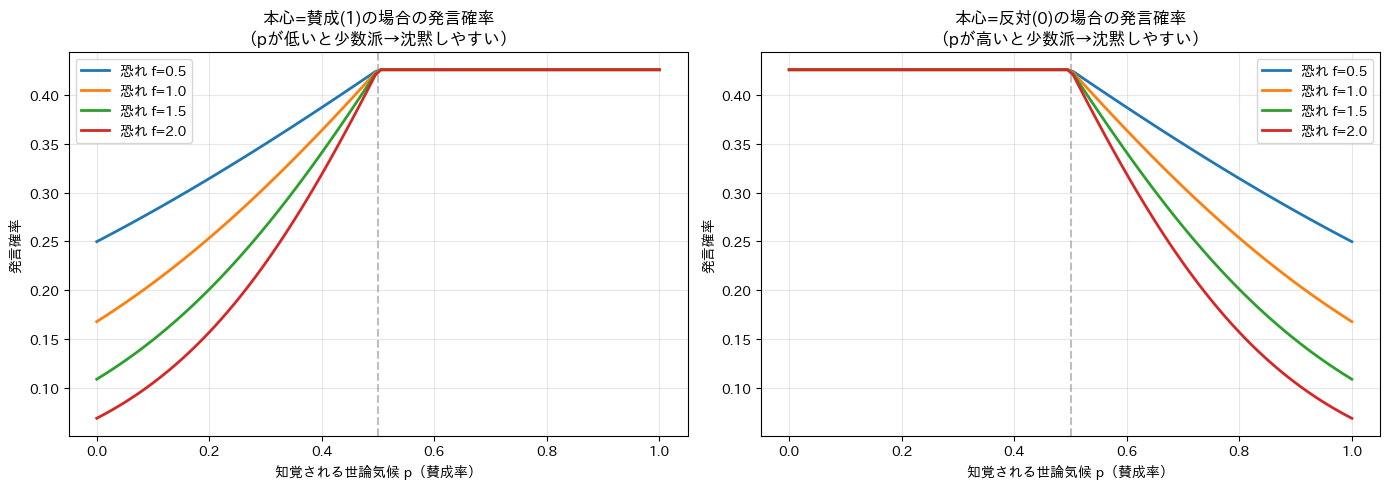

In [12]:
# 発言確率の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

p_values = np.linspace(0, 1, 100)

# 左: 本心=賛成(1)の場合
ax1 = axes[0]
for fear in [0.5, 1.0, 1.5, 2.0]:
    probs = [compute_speaking_probability(1, p, fear) for p in p_values]
    ax1.plot(p_values, probs, label=f'恐れ f={fear}', linewidth=2)
ax1.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('知覚される世論気候 p（賛成率）')
ax1.set_ylabel('発言確率')
ax1.set_title('本心=賛成(1)の場合の発言確率\n（pが低いと少数派→沈黙しやすい）')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右: 本心=反対(0)の場合
ax2 = axes[1]
for fear in [0.5, 1.0, 1.5, 2.0]:
    probs = [compute_speaking_probability(0, p, fear) for p in p_values]
    ax2.plot(p_values, probs, label=f'恐れ f={fear}', linewidth=2)
ax2.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('知覚される世論気候 p（賛成率）')
ax2.set_ylabel('発言確率')
ax2.set_title('本心=反対(0)の場合の発言確率\n（pが高いと少数派→沈黙しやすい）')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

上のグラフから、沈黙の螺旋のメカニズムが見えます：

- **本心=賛成**の人は、世論が反対寄り（p < 0.5）だと少数派と感じ、発言確率が下がる
- **本心=反対**の人は、世論が賛成寄り（p > 0.5）だと少数派と感じ、発言確率が下がる
- **孤立への恐れ**が大きいほど、この効果が強くなる

---
## A2.8 ステップ6: シミュレーションの実装

In [13]:
def simulate_spiral_of_silence(
    n=600,
    graph_type="BA",
    seed=0,
    T=120,
    private_yes_rate=0.45,
    fear_mean=1.2,
    fear_sd=0.4,
    speak_cost=0.6,
    media_weight=0.20,
    media_bias=0.08,
    media_noise=0.03,
    core_fraction=0.03,
    core_speaking=0.95,
    weighted_visibility=True,
    intervention_t=None,
    media_bias_after=None,
):
    """
    沈黙の螺旋シミュレーション
    
    Parameters:
    -----------
    n : int
        ノード数
    graph_type : str
        ネットワークタイプ
    seed : int
        乱数シード
    T : int
        シミュレーション期間
    private_yes_rate : float
        私的に賛成の割合
    fear_mean, fear_sd : float
        孤立への恐れのパラメータ
    speak_cost : float
        発言の基礎コスト
    media_weight : float
        メディアの影響度
    media_bias : float
        メディアのバイアス
    media_noise : float
        メディアのノイズ
    core_fraction : float
        コア話者の割合
    core_speaking : float
        コア話者の発言確率
    weighted_visibility : bool
        可視性の重み付け
    intervention_t : int or None
        介入開始時点
    media_bias_after : float or None
        介入後のメディアバイアス
    
    Returns:
    --------
    dict: シミュレーション結果
    """
    rng = random.Random(seed)
    np_rng = np.random.default_rng(seed)
    
    # ネットワーク生成
    G = make_graph(n, graph_type, seed)
    nodes = list(G.nodes())
    N = len(nodes)
    
    # エージェント初期化
    b = {i: 1 if rng.random() < private_yes_rate else 0 for i in nodes}
    
    fear = {}
    for i in nodes:
        x = np_rng.normal(fear_mean, fear_sd)
        fear[i] = float(np.clip(x, 0.0, 3.0))
    
    degrees = dict(G.degree())
    sorted_nodes = sorted(nodes, key=lambda i: degrees[i], reverse=True)
    core_k = max(1, int(core_fraction * N))
    core = set(sorted_nodes[:core_k])
    
    if weighted_visibility:
        deg_vals = np.array([degrees[i] for i in nodes], dtype=float)
        if deg_vals.max() == deg_vals.min():
            vis = {i: 1.0 for i in nodes}
        else:
            scaled = (deg_vals - deg_vals.min()) / (deg_vals.max() - deg_vals.min())
            vis = {i: float(0.5 + 1.5 * scaled[idx]) for idx, i in enumerate(nodes)}
    else:
        vis = {i: 1.0 for i in nodes}
    
    # 初期状態
    s = {}
    for i in nodes:
        if rng.random() < 0.85:
            s[i] = b[i]
        else:
            s[i] = None
    
    # 記録
    hist_private = []
    hist_public = []
    hist_silence = []
    hist_minority_silence = []
    
    private_mean = float(np.mean([b[i] for i in nodes]))
    
    for t in range(T):
        # 現時点の公的平均
        visible_vals = [s[i] for i in nodes if s[i] is not None]
        public_mean = float(np.mean(visible_vals)) if len(visible_vals) else 0.5
        
        # メディアバイアス（介入考慮）
        current_bias = media_bias
        if intervention_t is not None and t >= intervention_t and media_bias_after is not None:
            current_bias = media_bias_after
        
        g_signal = compute_media_signal(public_mean, current_bias, media_noise, np_rng)
        
        # 同期更新
        s_next = {}
        for i in nodes:
            # コア話者
            if i in core and rng.random() < core_speaking:
                s_next[i] = b[i]
                continue
            
            p_i = compute_observed_climate(G, i, s, vis, g_signal, media_weight)
            p_speak = compute_speaking_probability(b[i], p_i, fear[i], speak_cost)
            
            if rng.random() < p_speak:
                s_next[i] = b[i]  # 発言するなら本心
            else:
                s_next[i] = None  # 沈黙
        
        s = s_next
        
        # ログ
        hist_private.append(private_mean)
        
        visible_vals = [s[i] for i in nodes if s[i] is not None]
        public_mean = float(np.mean(visible_vals)) if len(visible_vals) else 0.5
        hist_public.append(public_mean)
        
        silence_rate = 1.0 - (len(visible_vals) / N)
        hist_silence.append(silence_rate)
        
        # 少数派の沈黙率
        minority_opinion = 0 if public_mean > 0.5 else 1
        minority_nodes = [i for i in nodes if b[i] == minority_opinion]
        if len(minority_nodes) == 0:
            hist_minority_silence.append(0.0)
        else:
            minority_silent = np.mean([1.0 if s[i] is None else 0.0 for i in minority_nodes])
            hist_minority_silence.append(float(minority_silent))
    
    return {
        "G": G,
        "b": b,
        "s": s,
        "fear": fear,
        "core": core,
        "hist_private": np.array(hist_private),
        "hist_public": np.array(hist_public),
        "hist_silence": np.array(hist_silence),
        "hist_minority_silence": np.array(hist_minority_silence),
        "meta": {
            "graph_type": graph_type,
            "private_yes_rate": private_yes_rate,
            "fear_mean": fear_mean,
            "fear_sd": fear_sd,
            "speak_cost": speak_cost,
            "media_weight": media_weight,
            "media_bias": media_bias,
            "core_fraction": core_fraction,
            "core_speaking": core_speaking,
            "weighted_visibility": weighted_visibility,
            "intervention_t": intervention_t,
            "media_bias_after": media_bias_after,
        }
    }

---
## A2.9 ステップ7: 結果の可視化

In [14]:
def plot_spiral_results(res):
    """
    シミュレーション結果を可視化
    """
    hp = res["hist_private"]
    hpub = res["hist_public"]
    hsil = res["hist_silence"]
    hms = res["hist_minority_silence"]
    meta = res["meta"]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左: 私的 vs 見える世論
    ax1 = axes[0]
    ax1.plot(hp, label="私的意見（賛成割合）", linewidth=2, color='blue')
    ax1.plot(hpub, label="見える発言（賛成割合）", linewidth=2, color='orange')
    ax1.fill_between(range(len(hp)), hp, hpub, alpha=0.3, color='orange')
    ax1.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("時点 t")
    ax1.set_ylabel("割合")
    title = f"沈黙の螺旋：私的 vs 見える世論（{meta['graph_type']}）"
    if meta["intervention_t"] is not None:
        ax1.axvline(meta["intervention_t"], linestyle="--", color='green',
                   label='介入')
        title += f"\n介入 t={meta['intervention_t']}"
    ax1.set_title(title)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 右: 沈黙率
    ax2 = axes[1]
    ax2.plot(hsil, label="沈黙率（全体）", linewidth=2, color='gray')
    ax2.plot(hms, label="少数派の沈黙率", linewidth=2, color='red')
    ax2.set_ylim(0, 1)
    ax2.set_xlabel("時点 t")
    ax2.set_ylabel("割合")
    ax2.set_title("沈黙の螺旋：少数派の沈黙")
    if meta["intervention_t"] is not None:
        ax2.axvline(meta["intervention_t"], linestyle="--", color='green',
                   label='介入')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

シミュレーション1: 基本ケース（メディアが賛成寄りにバイアス）

私的意見（賛成割合）: 44.9%
見える発言（賛成割合）: 39.8%
最終沈黙率: 65.1%
少数派の沈黙率: 69.1%


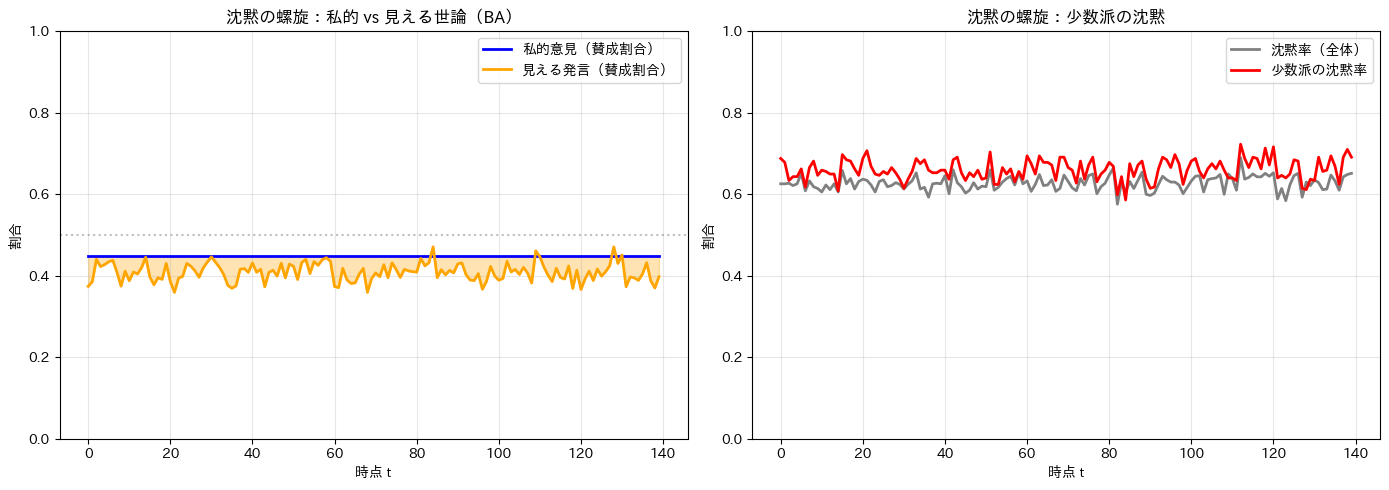

In [15]:
# シミュレーション1: 基本ケース
print("=" * 60)
print("シミュレーション1: 基本ケース（メディアが賛成寄りにバイアス）")
print("=" * 60)

res1 = simulate_spiral_of_silence(
    n=700,
    graph_type="BA",
    seed=2,
    private_yes_rate=0.45,  # 本心はほぼ拮抗
    fear_mean=1.3,
    fear_sd=0.45,
    speak_cost=0.55,
    media_weight=0.22,
    media_bias=0.10,  # メディアが賛成寄り
    core_fraction=0.03,
    core_speaking=0.95,
    weighted_visibility=True,
    T=140,
)

# 結果サマリー
print(f"\n私的意見（賛成割合）: {np.mean(list(res1['b'].values())):.1%}")
visible = [v for v in res1['s'].values() if v is not None]
print(f"見える発言（賛成割合）: {np.mean(visible):.1%}")
print(f"最終沈黙率: {res1['hist_silence'][-1]:.1%}")
print(f"少数派の沈黙率: {res1['hist_minority_silence'][-1]:.1%}")

plot_spiral_results(res1)

### 結果の解釈

上のグラフから沈黙の螺旋が観察できます：

1. **私的意見は約45%賛成**だが、メディアバイアスにより**見える発言は賛成が多い**
2. **反対派（少数派に見える側）の沈黙率が高い**
3. 時間とともに螺旋が進行し、格差が維持・拡大される

---
## A2.10 ステップ8: 介入効果の分析

メディアのバイアスを途中で変更すると、螺旋はどうなるでしょうか？

シミュレーション2: t=70でメディアバイアスを反転

私的意見（賛成割合）: 44.9%
見える発言（賛成割合）: 38.3%
最終沈黙率: 65.3%
少数派の沈黙率: 70.4%


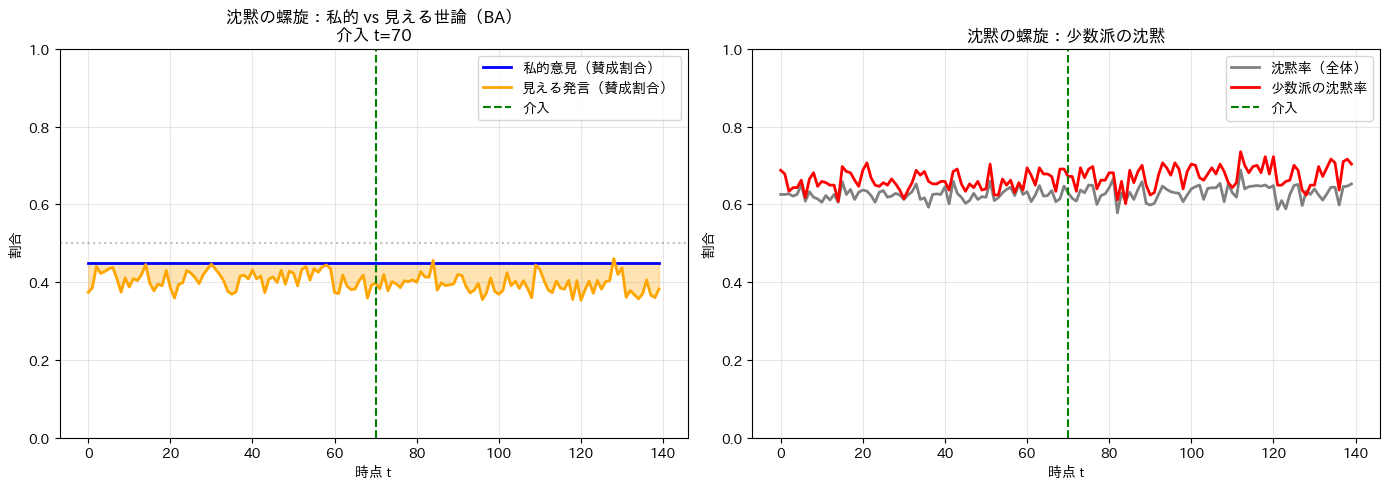

In [16]:
# シミュレーション2: メディアバイアスの介入
print("=" * 60)
print("シミュレーション2: t=70でメディアバイアスを反転")
print("=" * 60)

res2 = simulate_spiral_of_silence(
    n=700,
    graph_type="BA",
    seed=2,
    private_yes_rate=0.45,
    fear_mean=1.3,
    fear_sd=0.45,
    speak_cost=0.55,
    media_weight=0.22,
    media_bias=0.10,
    intervention_t=70,
    media_bias_after=-0.02,  # バイアスを弱める/反転
    core_fraction=0.03,
    core_speaking=0.95,
    weighted_visibility=True,
    T=140,
)

print(f"\n私的意見（賛成割合）: {np.mean(list(res2['b'].values())):.1%}")
visible2 = [v for v in res2['s'].values() if v is not None]
print(f"見える発言（賛成割合）: {np.mean(visible2):.1%}")
print(f"最終沈黙率: {res2['hist_silence'][-1]:.1%}")
print(f"少数派の沈黙率: {res2['hist_minority_silence'][-1]:.1%}")

plot_spiral_results(res2)

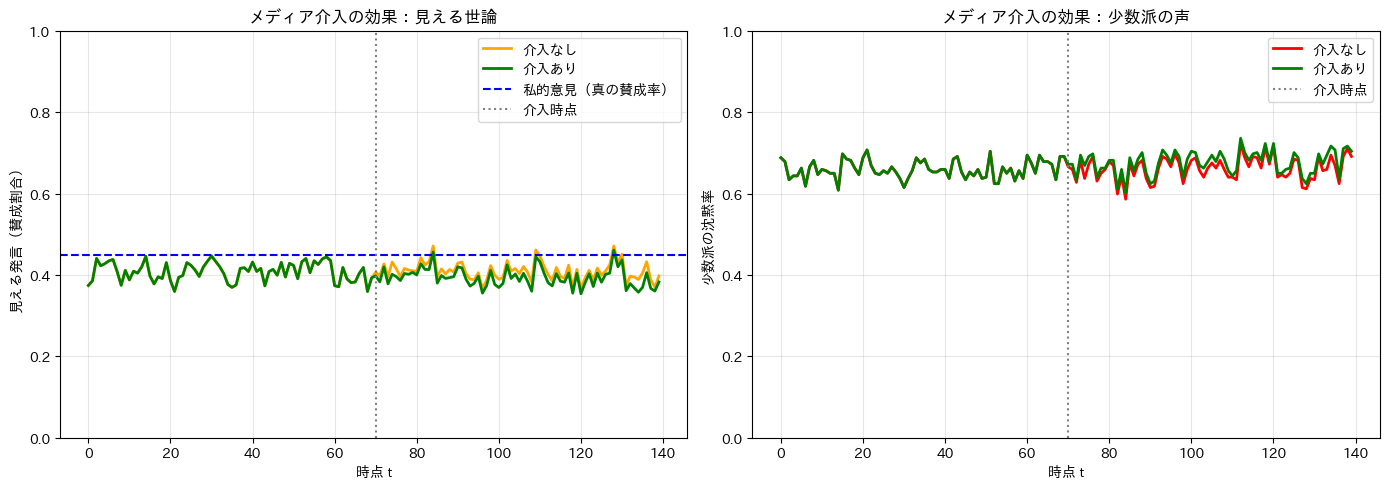

In [17]:
# 介入あり/なしの比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 見える発言の比較
ax1 = axes[0]
ax1.plot(res1['hist_public'], label='介入なし', linewidth=2, color='orange')
ax1.plot(res2['hist_public'], label='介入あり', linewidth=2, color='green')
ax1.axhline(res1['hist_private'][0], linestyle='--', color='blue',
           label='私的意見（真の賛成率）')
ax1.axvline(70, linestyle=':', color='gray', label='介入時点')
ax1.set_xlabel('時点 t')
ax1.set_ylabel('見える発言（賛成割合）')
ax1.set_title('メディア介入の効果：見える世論')
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# 右: 少数派沈黙率の比較
ax2 = axes[1]
ax2.plot(res1['hist_minority_silence'], label='介入なし', linewidth=2, color='red')
ax2.plot(res2['hist_minority_silence'], label='介入あり', linewidth=2, color='green')
ax2.axvline(70, linestyle=':', color='gray', label='介入時点')
ax2.set_xlabel('時点 t')
ax2.set_ylabel('少数派の沈黙率')
ax2.set_title('メディア介入の効果：少数派の声')
ax2.legend()
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## A2.11 ステップ9: コア話者の役割

コア話者（オピニオンリーダー）の割合を変えると、螺旋にどう影響するでしょうか？

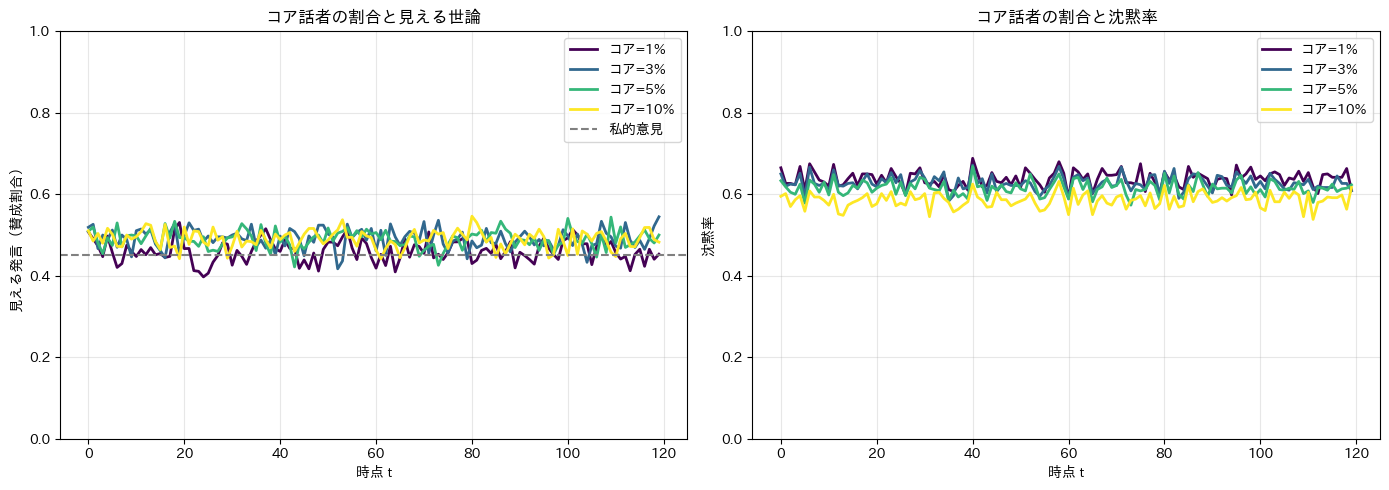

In [18]:
# コア話者の割合を変えた比較
core_fractions = [0.01, 0.03, 0.05, 0.10]
results_core = {}

for cf in core_fractions:
    results_core[cf] = simulate_spiral_of_silence(
        n=600,
        graph_type="BA",
        seed=42,
        private_yes_rate=0.45,
        fear_mean=1.3,
        speak_cost=0.55,
        media_bias=0.10,
        core_fraction=cf,
        core_speaking=0.95,
        T=120,
    )

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.viridis(np.linspace(0, 1, len(core_fractions)))

for idx, cf in enumerate(core_fractions):
    res = results_core[cf]
    axes[0].plot(res['hist_public'], label=f'コア={cf:.0%}',
                 color=colors[idx], linewidth=2)
    axes[1].plot(res['hist_silence'], label=f'コア={cf:.0%}',
                 color=colors[idx], linewidth=2)

axes[0].axhline(0.45, linestyle='--', color='gray', label='私的意見')
axes[0].set_xlabel('時点 t')
axes[0].set_ylabel('見える発言（賛成割合）')
axes[0].set_title('コア話者の割合と見える世論')
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('時点 t')
axes[1].set_ylabel('沈黙率')
axes[1].set_title('コア話者の割合と沈黙率')
axes[1].legend()
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# コア話者の効果まとめ
print("コア話者の割合と螺旋の強さ")
print("=" * 50)
print(f"{'コア割合':^10} | {'最終見える発言':^15} | {'最終沈黙率':^12}")
print("-" * 50)

for cf in core_fractions:
    res = results_core[cf]
    final_public = res['hist_public'][-1]
    final_silence = res['hist_silence'][-1]
    print(f"{cf:^10.0%} | {final_public:^15.1%} | {final_silence:^12.1%}")

コア話者の割合と螺旋の強さ
   コア割合    |     最終見える発言     |    最終沈黙率    
--------------------------------------------------
    1%     |      45.3%      |    61.0%    
    3%     |      54.5%      |    60.8%    
    5%     |      50.0%      |    62.3%    
   10%     |      48.3%      |    61.7%    


---
## A2.12 ステップ10: ネットワーク上での可視化

In [20]:
def visualize_spiral_network(res, title="沈黙の螺旋：ネットワーク状態"):
    """
    ネットワーク上のエージェント状態を可視化
    """
    G = res['G']
    b = res['b']
    s = res['s']
    core = res['core']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    pos = nx.spring_layout(G, seed=42)
    
    # 左: 私的意見（コア話者を強調）
    ax1 = axes[0]
    colors_private = []
    sizes = []
    for n in G.nodes():
        if b[n] == 1:
            colors_private.append('#3498db')  # 青=賛成
        else:
            colors_private.append('#e74c3c')  # 赤=反対
        sizes.append(100 if n in core else 20)
    
    nx.draw(G, pos, ax=ax1, node_size=sizes, node_color=colors_private,
            edge_color='gray', alpha=0.7, width=0.3)
    ax1.set_title('私的意見\n青=賛成, 赤=反対, 大=コア話者')
    
    # 右: 公的発言（沈黙を含む）
    ax2 = axes[1]
    colors_public = []
    for n in G.nodes():
        if s[n] is None:
            colors_public.append('#95a5a6')  # 灰=沈黙
        elif s[n] == 1:
            colors_public.append('#3498db')  # 青=賛成
        else:
            colors_public.append('#e74c3c')  # 赤=反対
    
    nx.draw(G, pos, ax=ax2, node_size=sizes, node_color=colors_public,
            edge_color='gray', alpha=0.7, width=0.3)
    ax2.set_title('公的発言\n青=賛成, 赤=反対, 灰=沈黙')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

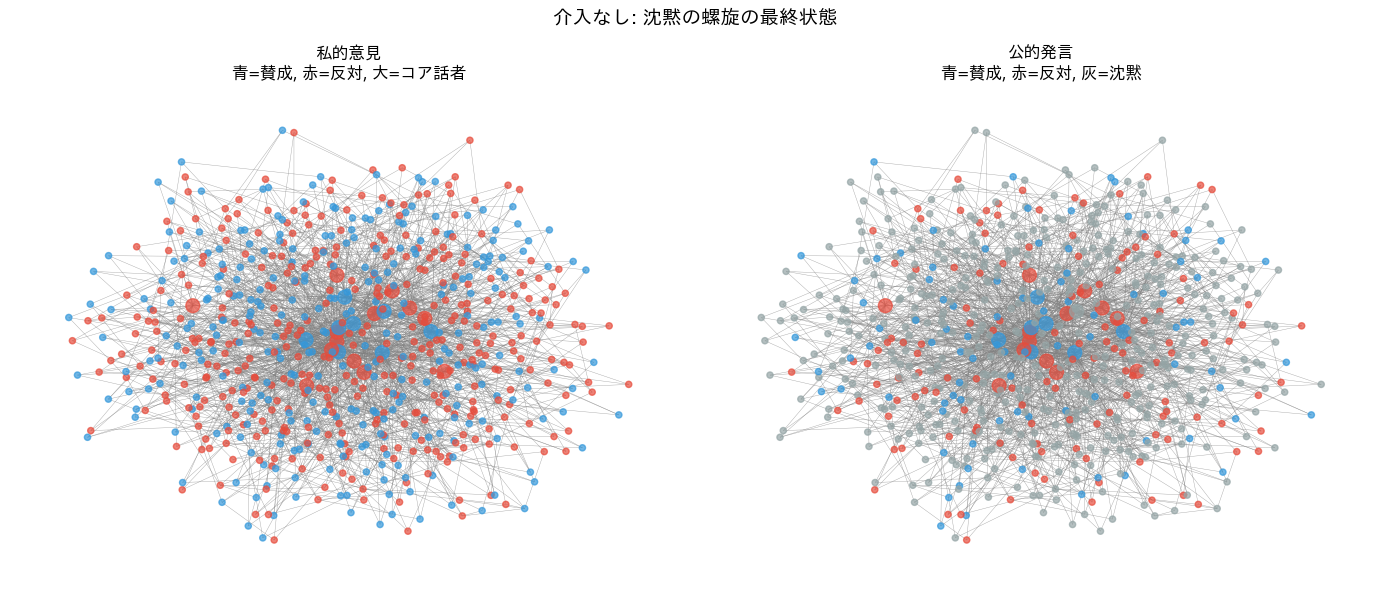

In [21]:
# ネットワーク可視化
visualize_spiral_network(res1, "介入なし: 沈黙の螺旋の最終状態")

In [22]:
# 沈黙しているノードの分析
silent_nodes = [n for n in res1['G'].nodes() if res1['s'][n] is None]
speaking_nodes = [n for n in res1['G'].nodes() if res1['s'][n] is not None]

# 沈黙者の属性を分析
silent_private = [res1['b'][n] for n in silent_nodes]
silent_fear = [res1['fear'][n] for n in silent_nodes]

speaking_private = [res1['b'][n] for n in speaking_nodes]
speaking_fear = [res1['fear'][n] for n in speaking_nodes]

print("沈黙者 vs 発言者の比較")
print("=" * 40)
print(f"沈黙者数: {len(silent_nodes)} ({len(silent_nodes)/len(res1['G'].nodes()):.1%})")
print(f"  - 賛成派の割合: {np.mean(silent_private):.1%}")
print(f"  - 孤立への恐れ: {np.mean(silent_fear):.2f}")
print(f"\n発言者数: {len(speaking_nodes)} ({len(speaking_nodes)/len(res1['G'].nodes()):.1%})")
print(f"  - 賛成派の割合: {np.mean(speaking_private):.1%}")
print(f"  - 孤立への恐れ: {np.mean(speaking_fear):.2f}")

沈黙者 vs 発言者の比較
沈黙者数: 456 (65.1%)
  - 賛成派の割合: 47.6%
  - 孤立への恐れ: 1.28

発言者数: 244 (34.9%)
  - 賛成派の割合: 39.8%
  - 孤立への恐れ: 1.29


---
## 練習問題

### 練習問題1: 孤立への恐れの影響

`fear_mean`（孤立への恐れの平均）を0.5, 1.0, 1.5, 2.0と変化させて、螺旋の強さがどう変わるか調べてください。

In [23]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
fear_means = [0.5, 1.0, 1.5, 2.0]
results_fear = {}

for fm in fear_means:
    results_fear[fm] = simulate_spiral_of_silence(
        n=600,
        graph_type="BA",
        seed=42,
        private_yes_rate=0.45,
        fear_mean=fm,
        fear_sd=0.4,
        media_bias=0.10,
        T=120,
    )

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.Reds(np.linspace(0.3, 1, len(fear_means)))

for idx, fm in enumerate(fear_means):
    res = results_fear[fm]
    axes[0].plot(res['hist_public'], label=f'恐れ={fm}',
                 color=colors[idx], linewidth=2)
    axes[1].plot(res['hist_minority_silence'], label=f'恐れ={fm}',
                 color=colors[idx], linewidth=2)

axes[0].axhline(0.45, linestyle='--', color='gray', label='私的意見')
axes[0].set_xlabel('時点 t')
axes[0].set_ylabel('見える発言（賛成割合）')
axes[0].set_title('孤立への恐れと見える世論')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('時点 t')
axes[1].set_ylabel('少数派の沈黙率')
axes[1].set_title('孤立への恐れと少数派の沈黙')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 結果サマリー
print("孤立への恐れ | 最終見える発言 | 少数派沈黙率")
print("-" * 45)
for fm in fear_means:
    res = results_fear[fm]
    print(f"    {fm:.1f}     |     {res['hist_public'][-1]:.1%}      |    {res['hist_minority_silence'][-1]:.1%}")
```
</details>

### 練習問題2: ネットワーク構造の影響

3種類のネットワーク（ER, WS, BA）で沈黙の螺旋を比較し、どの構造で螺旋が強くなるか調べてください。

In [24]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
graph_types = ["ER", "WS", "BA"]
results_graph = {}

for gt in graph_types:
    results_graph[gt] = simulate_spiral_of_silence(
        n=600,
        graph_type=gt,
        seed=42,
        private_yes_rate=0.45,
        fear_mean=1.3,
        media_bias=0.10,
        T=120,
    )

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = {'ER': 'blue', 'WS': 'orange', 'BA': 'green'}

for ax, gt in zip(axes, graph_types):
    res = results_graph[gt]
    ax.plot(res['hist_private'], label='私的意見', linestyle='--', color='gray')
    ax.plot(res['hist_public'], label='見える発言', color=colors[gt], linewidth=2)
    ax.fill_between(range(len(res['hist_private'])),
                    res['hist_private'], res['hist_public'],
                    alpha=0.3, color=colors[gt])
    ax.set_ylim(0, 1)
    ax.set_xlabel('時点 t')
    ax.set_ylabel('割合')
    ax.set_title(f'{gt}ネットワーク\n最終沈黙率: {res["hist_silence"][-1]:.1%}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ネットワーク特性との関係
print("ネットワーク構造と沈黙の螺旋")
print("=" * 60)
for gt in graph_types:
    res = results_graph[gt]
    G = res['G']
    avg_degree = np.mean([d for n, d in G.degree()])
    clustering = nx.average_clustering(G)
    
    print(f"\n{gt}:")
    print(f"  平均次数: {avg_degree:.1f}")
    print(f"  クラスタ係数: {clustering:.3f}")
    print(f"  最終見える発言: {res['hist_public'][-1]:.1%}")
    print(f"  少数派沈黙率: {res['hist_minority_silence'][-1]:.1%}")
```
</details>

### 練習問題3: メディア影響度の分析

`media_weight`（メディアの影響度）を0.0, 0.2, 0.4, 0.6と変化させて、メディアの力が螺旋にどう影響するか調べてください。

In [25]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
media_weights = [0.0, 0.2, 0.4, 0.6]
results_media = {}

for mw in media_weights:
    results_media[mw] = simulate_spiral_of_silence(
        n=600,
        graph_type="BA",
        seed=42,
        private_yes_rate=0.45,
        fear_mean=1.3,
        media_weight=mw,
        media_bias=0.10,
        T=120,
    )

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.Blues(np.linspace(0.3, 1, len(media_weights)))

for idx, mw in enumerate(media_weights):
    res = results_media[mw]
    label = 'ローカルのみ' if mw == 0 else f'メディア={mw:.0%}'
    axes[0].plot(res['hist_public'], label=label,
                 color=colors[idx], linewidth=2)
    axes[1].plot(res['hist_minority_silence'], label=label,
                 color=colors[idx], linewidth=2)

axes[0].axhline(0.45, linestyle='--', color='gray', label='私的意見')
axes[0].set_xlabel('時点 t')
axes[0].set_ylabel('見える発言（賛成割合）')
axes[0].set_title('メディア影響度と見える世論')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('時点 t')
axes[1].set_ylabel('少数派の沈黙率')
axes[1].set_title('メディア影響度と少数派の沈黙')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 結論
print("結論:")
print("メディア影響度が高いほど、バイアスの効果が強まり、")
print("螺旋がより顕著になる傾向があります。")
```
</details>

---
## A2.13 章のまとめ

この付録では以下を学びました：

1. **沈黙の螺旋理論**: 少数派が沈黙し、多数派がより多数に見える悪循環
2. **世論気候の知覚**: ローカル情報とメディア情報の統合
3. **孤立への恐れ**: 個人差のある心理的抵抗とその効果
4. **発言確率モデル**: 少数派度と恐れに基づく確率的決定
5. **コア話者の役割**: オピニオンリーダーが螺旋を緩和する可能性
6. **メディア介入**: バイアス変更による螺旋の変化

### 多元的無知との比較

| 側面 | 多元的無知（A1） | 沈黙の螺旋（A2） |
|------|------------------|------------------|
| 発言内容 | 本心と異なることを言う | 本心を言うか沈黙 |
| メカニズム | しきい値による同調 | 孤立への恐れによる沈黙 |
| 結果 | 公的発言が歪む | 少数派の声が消える |

### 発展課題
- 時間変化する私的意見
- 複数のトピック（争点）
- エコーチェンバー効果との組み合わせ
- 実データとの比較検証

---
## 参考資料

- Noelle-Neumann, E. (1974). The Spiral of Silence: A Theory of Public Opinion. Journal of Communication.
- Noelle-Neumann, E. (1993). The Spiral of Silence: Public Opinion - Our Social Skin. University of Chicago Press.
- [NetworkX公式ドキュメント](https://networkx.org/documentation/stable/)